PSO(0/49): loss=1.883911988523636, w=8.449039385718791, b=66.64552514643006
PSO(1/49): loss=1.883911988523636, w=8.449039385718791, b=66.64552514643006
PSO(2/49): loss=1.883911988523636, w=8.449039385718791, b=66.64552514643006
PSO(3/49): loss=1.883911988523636, w=8.449039385718791, b=66.64552514643006
PSO(4/49): loss=1.5055726307852237, w=7.242243939630811, b=67.16933608876805
PSO(5/49): loss=1.5055726307852237, w=7.242243939630811, b=67.16933608876805
PSO(6/49): loss=1.5055726307852237, w=7.242243939630811, b=67.16933608876805
PSO(7/49): loss=1.5055726307852237, w=7.242243939630811, b=67.16933608876805
PSO(8/49): loss=1.5055726307852237, w=7.242243939630811, b=67.16933608876805
PSO(9/49): loss=1.4956831730441018, w=6.051891712329748, b=67.65062107214786
PSO(10/49): loss=1.4956831730441018, w=6.051891712329748, b=67.65062107214786
PSO(11/49): loss=1.4956831730441018, w=6.051891712329748, b=67.65062107214786
PSO(12/49): loss=1.4956831730441018, w=6.051891712329748, b=67.65062107214786


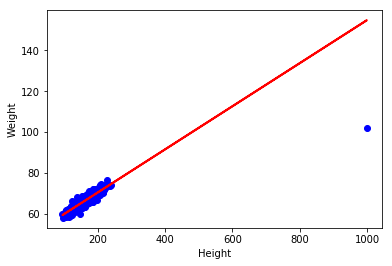

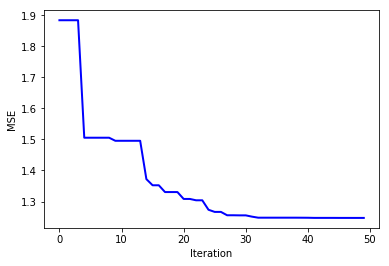

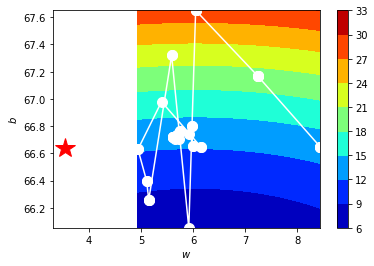

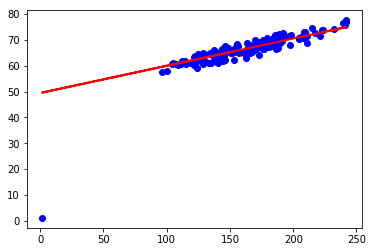

In [9]:
# -*- coding: utf-8 -*-

"""
This is an example to perform simple linear regression algorithm on the dataset (weight and height),
where x = weight and y = height.
"""
import pandas as pd
import numpy as np
import datetime
import random
import math

from sklearn.linear_model import LinearRegression

from utilities.losses import compute_loss
from utilities.optimizers import gradient_descent, pso, mini_batch_gradient_descent
from sklearn.model_selection import train_test_split

# General settings
from utilities.visualization import visualize_train, visualize_test

seed = 309
# Freeze the random seed
random.seed(seed)
np.random.seed(seed)
train_test_split_test_size = 0.3

# Training settings
alpha = 0.1  # step size
max_iters = 50  # max iterations


def load_data():
    """
    Load Data from CSV
    :return: df    a panda data frame
    """
    df = pd.read_csv("../data/Part2Outliers.csv")
    return df


def data_preprocess(data):
    """
    Data preprocess:
        1. Split the entire dataset into train and test
        2. Split outputs and inputs
        3. Standardize train and test
        4. Add intercept dummy for computation convenience
    :param data: the given dataset (format: panda DataFrame)
    :return: train_data       train data contains only inputs
             train_labels     train data contains only labels
             test_data        test data contains only inputs
             test_labels      test data contains only labels
             train_data_full       train data (full) contains both inputs and labels
             test_data_full       test data (full) contains both inputs and labels
    """
    # Split the data into train and test
    train_data, test_data = train_test_split(data, test_size = train_test_split_test_size)

    # Pre-process data (both train and test)
    train_data_full = train_data.copy()
    train_data = train_data.drop(["Height"], axis = 1)
    train_labels = train_data_full["Height"]

    test_data_full = test_data.copy()
    test_data = test_data.drop(["Height"], axis = 1)
    test_labels = test_data_full["Height"]

    # Standardize the inputs
    train_mean = train_data.mean()
    train_std = train_data.std()
    train_data = (train_data - train_mean) / train_std
    test_data = (test_data - train_mean) / train_std

    # Tricks: add dummy intercept to both train and test
    train_data['intercept_dummy'] = pd.Series(1.0, index = train_data.index)
    test_data['intercept_dummy'] = pd.Series(1.0, index = test_data.index)
    return train_data, train_labels, test_data, test_labels, train_data_full, test_data_full


def learn(y, x, theta, max_iters, alpha, optimizer_type = "BGD", metric_type = "MSE"):
    """
    Learn to estimate the regression parameters (i.e., w and b)
    :param y:                   train labels
    :param x:                   train data
    :param theta:               model parameter
    :param max_iters:           max training iterations
    :param alpha:               step size
    :param optimizer_type:      optimizer type (default: Batch Gradient Descient): GD, SGD, MiniBGD or PSO
    :param metric_type:         metric type (MSE, RMSE, R2, MAE). NOTE: MAE can't be optimized by GD methods.
    :return: thetas              all updated model parameters tracked during the learning course
             losses             all losses tracked during the learning course
    """
    thetas = None
    losses = None
    if optimizer_type == "BGD":
        thetas, losses = gradient_descent(y, x, theta, max_iters, alpha, metric_type)
    elif optimizer_type == "MiniBGD":
        thetas, losses = mini_batch_gradient_descent(y, x, theta, max_iters, alpha, metric_type, mini_batch_size = 10)
    elif optimizer_type == "PSO":
        thetas, losses = pso(y, x, theta, max_iters, 100, metric_type)
    else:
        raise ValueError(
            "[ERROR] The optimizer '{ot}' is not defined, please double check and re-run your program.".format(
                ot = optimizer_type))
    return thetas, losses


if __name__ == '__main__':
    # Settings
    metric_type = "MAE"  # MSE, RMSE, MAE, R2
    optimizer_type = "PSO"  # PSO, BGD, MiniBGD

    # Step 1: Load Data
    data = load_data()

    # Step 2: Preprocess the data
    train_data, train_labels, test_data, test_labels, train_data_full, test_data_full = data_preprocess(data)

    # Step 3: Learning Start
    theta = np.array([0.0, 0.0])  # Initialize model parameter

    start_time = datetime.datetime.now()  # Track learning starting time
    thetas, losses = learn(train_labels.values, train_data.values, theta, max_iters, alpha, optimizer_type, metric_type)

    end_time = datetime.datetime.now()  # Track learning ending time
    exection_time = (end_time - start_time).total_seconds()  # Track execution time

    # Step 4: Results presentation
    print("Learn: execution time={t:.3f} seconds".format(t = exection_time))

    # Build baseline model
    print("R2:", -compute_loss(test_labels.values, test_data.values, thetas[-1], "R2"))  # R2 should be maximize
    print("MSE:", compute_loss(test_labels.values, test_data.values, thetas[-1], "MSE"))
    print("RMSE:", compute_loss(test_labels.values, test_data.values, thetas[-1], "RMSE"))
    print("MAE:", compute_loss(test_labels.values, test_data.values, thetas[-1], "MAE"))
    
    visualize_train(train_data_full,train_labels,train_data,thetas,losses,max_iters)
    visualize_test(test_data_full,test_data,thetas)
